In [26]:
# Dependencies
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from betacal import BetaCalibration
import ml_insights as mli
from sklearn.metrics import make_scorer, log_loss, brier_score_loss
import pandas as pd
import numpy as np

I am just going to use SVM for this example b/c it is really well known for the sigmoid-like shape it takes on for classification problems b/c it 'underneath the hood' (one of Dancho's favorite things to say! :) ) Support Vector Machines push the scores close to 0 or 1 and away from the middle so the scores get squished. Remember the algo will also come very close to 0 or 1 but because logloss will __infinitely__ punish the score if it is a 0 and it predicts a 1 and vice-versa, you also get this clumpiness. Anyway, I also choose this b/c we now know that h2o only leverages Platt, which is in essence a logit. Scikit-Learn has a cv calibration function and essentially two methods, Platt and Isotonic regression. Isotonic regression is non-parametric and can perform really well when you have loads of data but for reasons beyond the scope of this quick notebook I will leave it at that. 

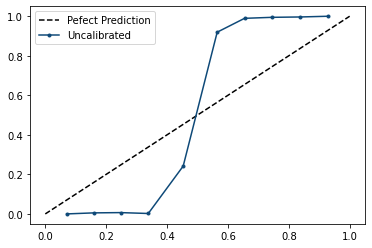

In [29]:
# Generate Binary Class Data
X, y = make_classification(n_samples=10000, n_classes=2, weights=[1,1], random_state=1)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# Fit a model
uncalib_model = SVC(probability=True)
uncalib_model.fit(X_train, y_train)
uncalib_probs = uncalib_model.decision_function(X_test)

# Reliability diagram
labels = ['Pefect Prediction', 'Uncalibrated']
uncalib_fop, uncalib_mpv = calibration_curve(y_test, uncalib_probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', color="black")
plt.plot(uncalib_mpv, uncalib_fop, marker='.', color = "#0E4978")
plt.legend(labels)
plt.show()

Above we have our classic sigmoid output from our model. Now we need to get that those scores to better fit that line I wrote as perfect prediction. The y-axis for the reliability diagram here are the observed probabilities, the x-axis is the predicted probabilities from the model. When the probabilities are under that perfect line our model is over confident. For example here at just over .4 on the x-axis the actual observed is at about .2. So put plainly our model predicts something little over 40% when it actually happens at 20%. That is terrible! This is what ML models do, and they almost all suffer from this problem, which is a serious issue when you need probabilities! The opposite is true when the predicted probabilities are above the perfect prediction line. So we would say the model was underconfident. That is the observed already above 90% is only at around 55-60% for the predicted. Our model is both over confident and under-confident. Our model is crap! This is why we need to calibrate! 

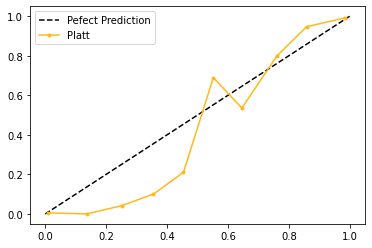

In [30]:
# Fit a model
platt_calib = CalibratedClassifierCV(uncalib_model, method='sigmoid', cv=5)
platt_calib.fit(X_train, y_train)
platt_probs = platt_calib.predict_proba(X_test)[:, 1]

# Reliability diagram
labels = ['Pefect Prediction', 'Platt']
platt_fop, platt_mpv = calibration_curve(y_test, platt_probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', color = 'black')
plt.plot(platt_mpv, platt_fop, marker='.', color = '#FFB81C')
plt.legend(labels)
plt.show()

Above we do some simple Platt Scaling and can certainly see some improvement particularly around 1 as the observed and predicted probabilities beging to hug the perfect prediction line.

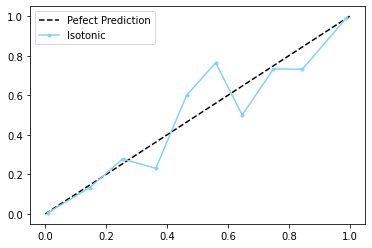

In [4]:
# Fit a model
iso_calib = CalibratedClassifierCV(uncalib_model, method='isotonic', cv=5)
iso_calib.fit(X_train, y_train)
iso_probs = iso_calib.predict_proba(X_test)[:, 1]

# Reliability diagram
labels = ['Pefect Prediction', 'Isotonic']
iso_fop, iso_mpv = calibration_curve(y_test, iso_probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', color = 'black')
plt.plot(iso_mpv, iso_fop, marker='.', color = '#83D4F1')
plt.legend(labels)
plt.show()

We repeat the same process but this time we use isotonic regression for calibration. Pretty decent improvement here just from eye-balling it, but lets plot everything together and also generate the logloss after calibration on our test set. You will see that in just this simple example Isotonic works better than Platt. Now the ```ml-insights``` package is more powerful as it also opens up the door to leveraging spline calibration and it has nicely integrated Beta calibration as well which is essentially logit with one extra degree of freedom. But I think you should see the logic here about calibration and importantly why we need to leverage it for the probabilities. 

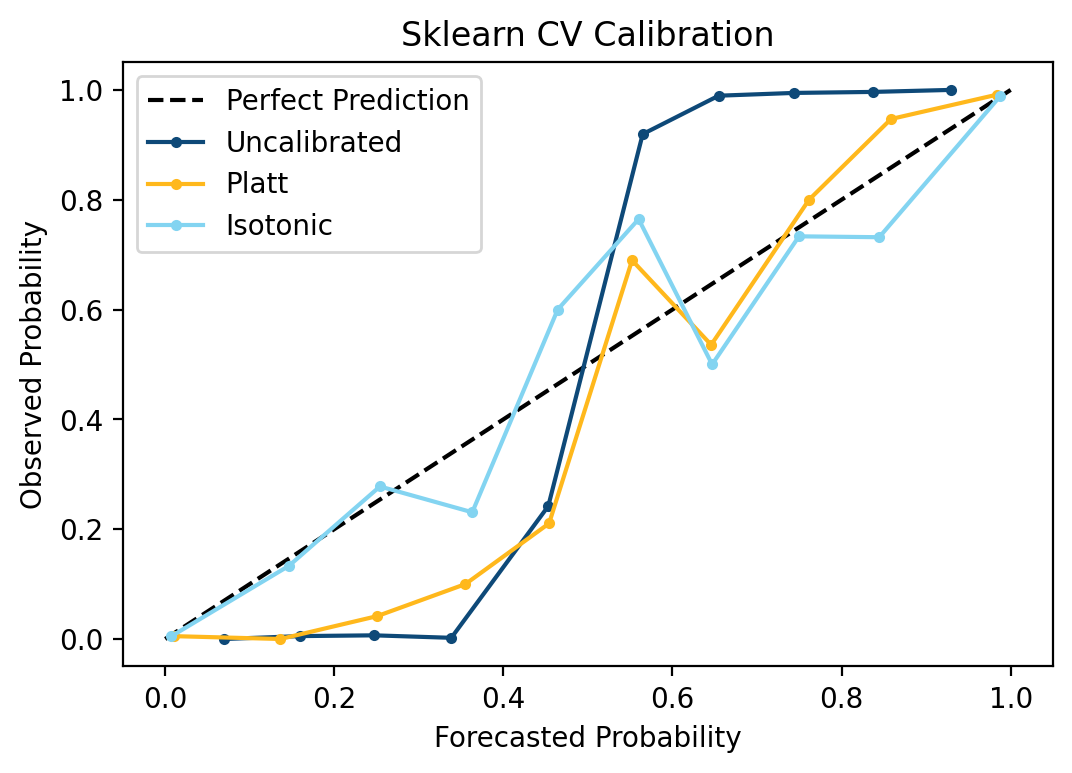

Uncalibrated log_loss           = 0.2529
Platt CV calibrated log_loss    = 0.0712
Isotonic CV calibrated log_loss = 0.0617


In [31]:
# Reliability diagram for Uncalibrated and Calibrated
fig, ax = plt.subplots(figsize=(6,4), dpi = 200)
labels = ['Perfect Prediction','Uncalibrated', 'Platt', 'Isotonic']
plt.plot([0, 1], [0, 1], linestyle='--', color = 'black')
plt.plot(uncalib_mpv, uncalib_fop, marker='.', color = "#0E4978")
plt.plot(platt_mpv, platt_fop, marker='.', color = '#FFB81C')
plt.plot(iso_mpv, iso_fop, marker='.', color = '#83D4F1')
plt.legend(labels)
ax.set(xlabel = 'Forecasted Probability', 
       ylabel = 'Observed Probability',
       title  = 'Sklearn CV Calibration')
plt.show()

# Logloss Results
print('Uncalibrated log_loss           = {0:.4f}'.format(log_loss(y_test, uncalib_probs)))
print('Platt CV calibrated log_loss    = {0:.4f}'.format(log_loss(y_test, platt_probs)))
print('Isotonic CV calibrated log_loss = {0:.4f}'.format(log_loss(y_test, iso_probs)))